In [1]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
import warnings
warnings.simplefilter("ignore")

warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available


SynthGRB_0


Fitting GBM_n3 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting GBM_n4 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting GBM_n5 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting GBM_b1 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/7 [00:00<?, ?it/s]

SynthGRB_1


Fitting GBM_n5 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/9 [00:00<?, ?it/s]

Fitting GBM_n3 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/9 [00:00<?, ?it/s]

Fitting GBM_n2 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/9 [00:00<?, ?it/s]

Fitting GBM_b1 background:   0%|          | 0/128 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/9 [00:00<?, ?it/s]

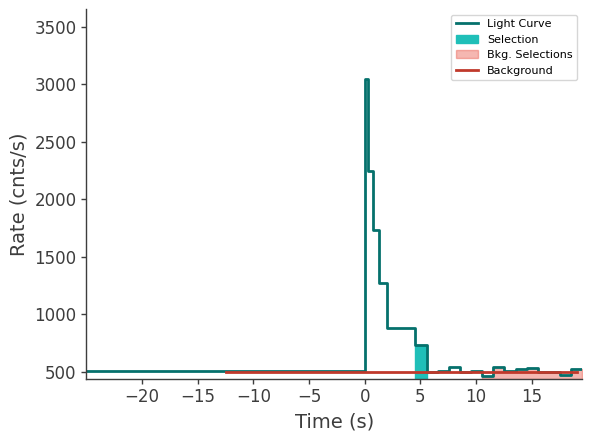

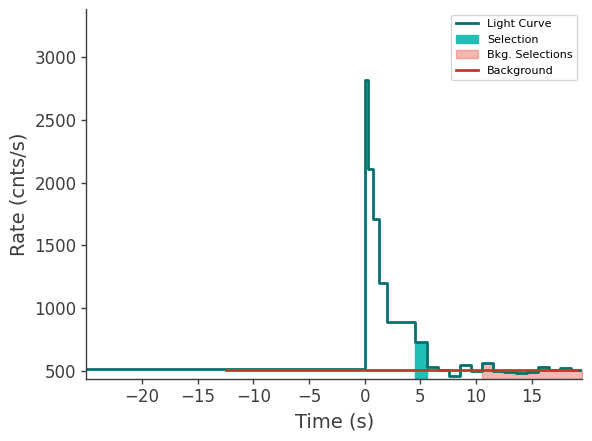

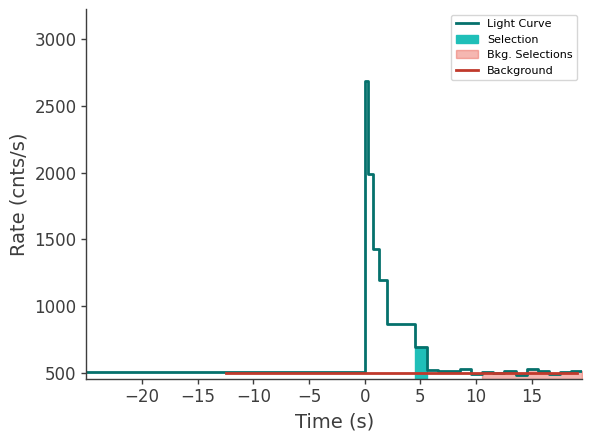

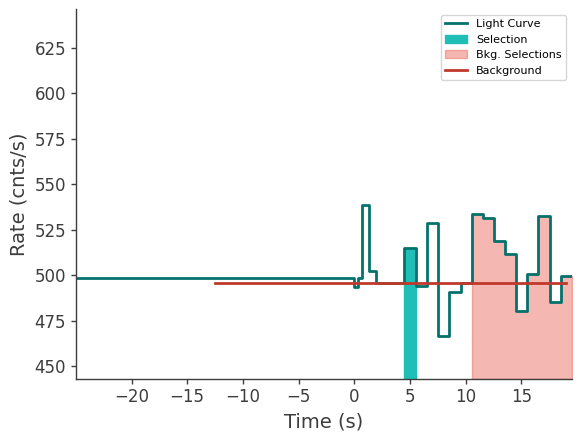

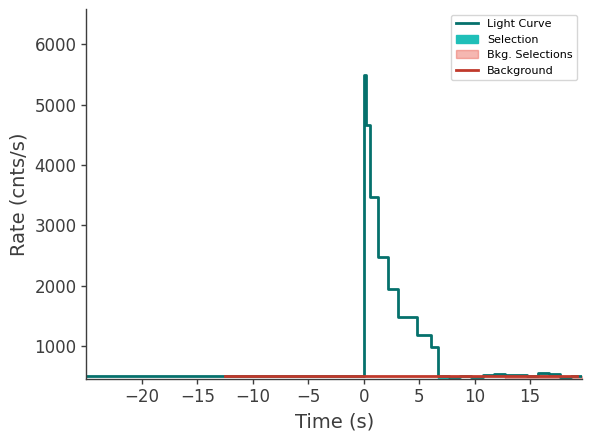

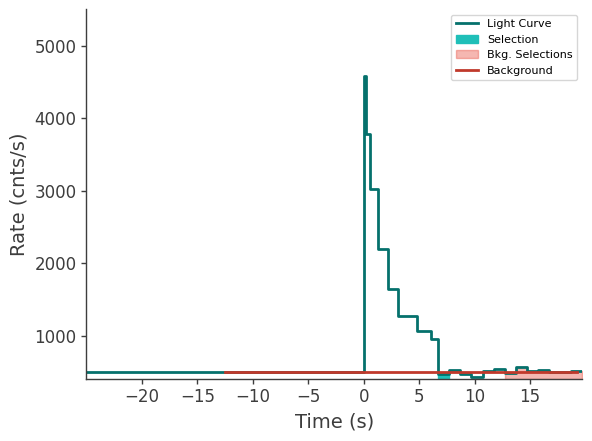

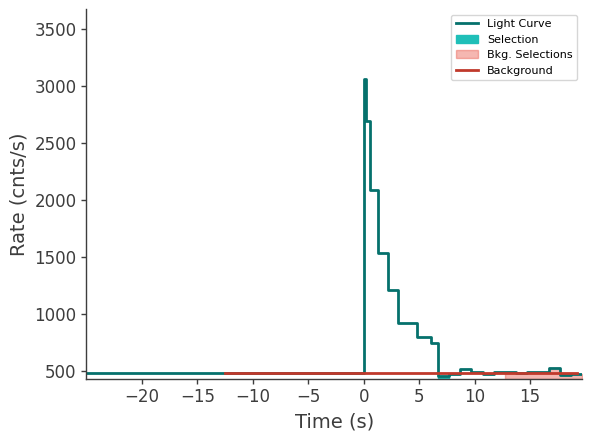

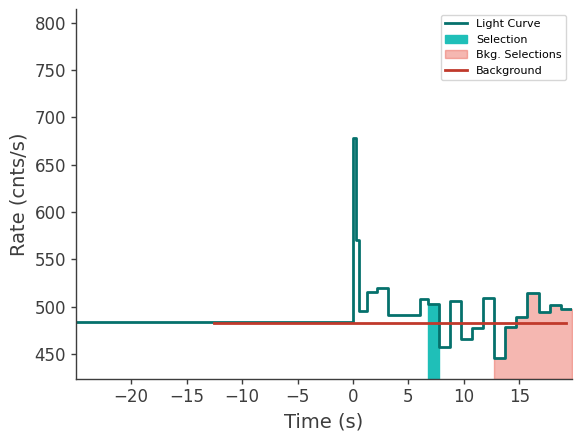

In [2]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True)

In [3]:
ab.write_yaml("test_proc.yml")

In [4]:
ds = DataSet.from_yaml("test_proc.yml")


In [5]:
ds.to_hdf5_file("sgrb.h5")

In [6]:
ds.to_hdf5_file("sgrb.h5", sig_threshold=40)

shit
shit
shit
shit
shit


In [7]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [8]:
m = get_model("cpl_simple_chunked")

In [9]:
m.clean_model()

In [12]:
m.build_model()

INFO:cmdstanpy:compiling stan file /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked.stan to exe file /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked
INFO:cmdstanpy:compiled model executable: /home/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked

--- Compiling the main object file. This might take up to a minute. ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes     -DSTAN_THREADS -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -o src/cmdstan/main_threads.o src/cmdstan/main.cpp
In file included from stan/lib/stan_math/lib/boost_1.75.0/boost/multi_array/multi_array_ref.hpp:32,
        

In [13]:
data = ds.to_stan_dict()

n_threads = 3
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    # inits= {'alpha':-1.},
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    show_progress=True,
)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [14]:
m.model.sample?

Signature:
m.model.sample(
    data: Union[Mapping[str, Any], str, NoneType] = None,
    chains: Union[int, NoneType] = None,
    parallel_chains: Union[int, NoneType] = None,
    threads_per_chain: Union[int, NoneType] = None,
    seed: Union[int, List[int], NoneType] = None,
    chain_ids: Union[int, List[int], NoneType] = None,
    inits: Union[Dict[str, float], float, str, List[str], NoneType] = None,
    iter_warmup: Union[int, NoneType] = None,
    iter_sampling: Union[int, NoneType] = None,
    save_warmup: bool = False,
    thin: Union[int, NoneType] = None,
    max_treedepth: Union[int, NoneType] = None,
    metric: Union[str, Dict[str, Any], List[str], List[Dict[str, Any]], NoneType] = None,
    step_size: Union[float, List[float], NoneType] = None,
    adapt_engaged: bool = True,
    adapt_delta: Union[float, NoneType] = None,
    adapt_init_phase: Union[int, NoneType] = None,
    adapt_metric_window: Union[int, NoneType] = None,
    adapt_step_size: Union[int, NoneType] = N

In [15]:
res = av.from_cmdstanpy(fit)

In [18]:
res.sample_stats.treedepth.max()

AttributeError: 'Dataset' object has no attribute 'treedepth'

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_sigma'}>,
        <AxesSubplot:title={'center':'log_energy_flux_sigma'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_raw'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux'}>,
        <AxesSubplot:title={'center':'log_energy_flux'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu'}>],
       [<AxesSubplot:title={'center':'energy_flux'}>,
        <AxesSubplot:title={'cente

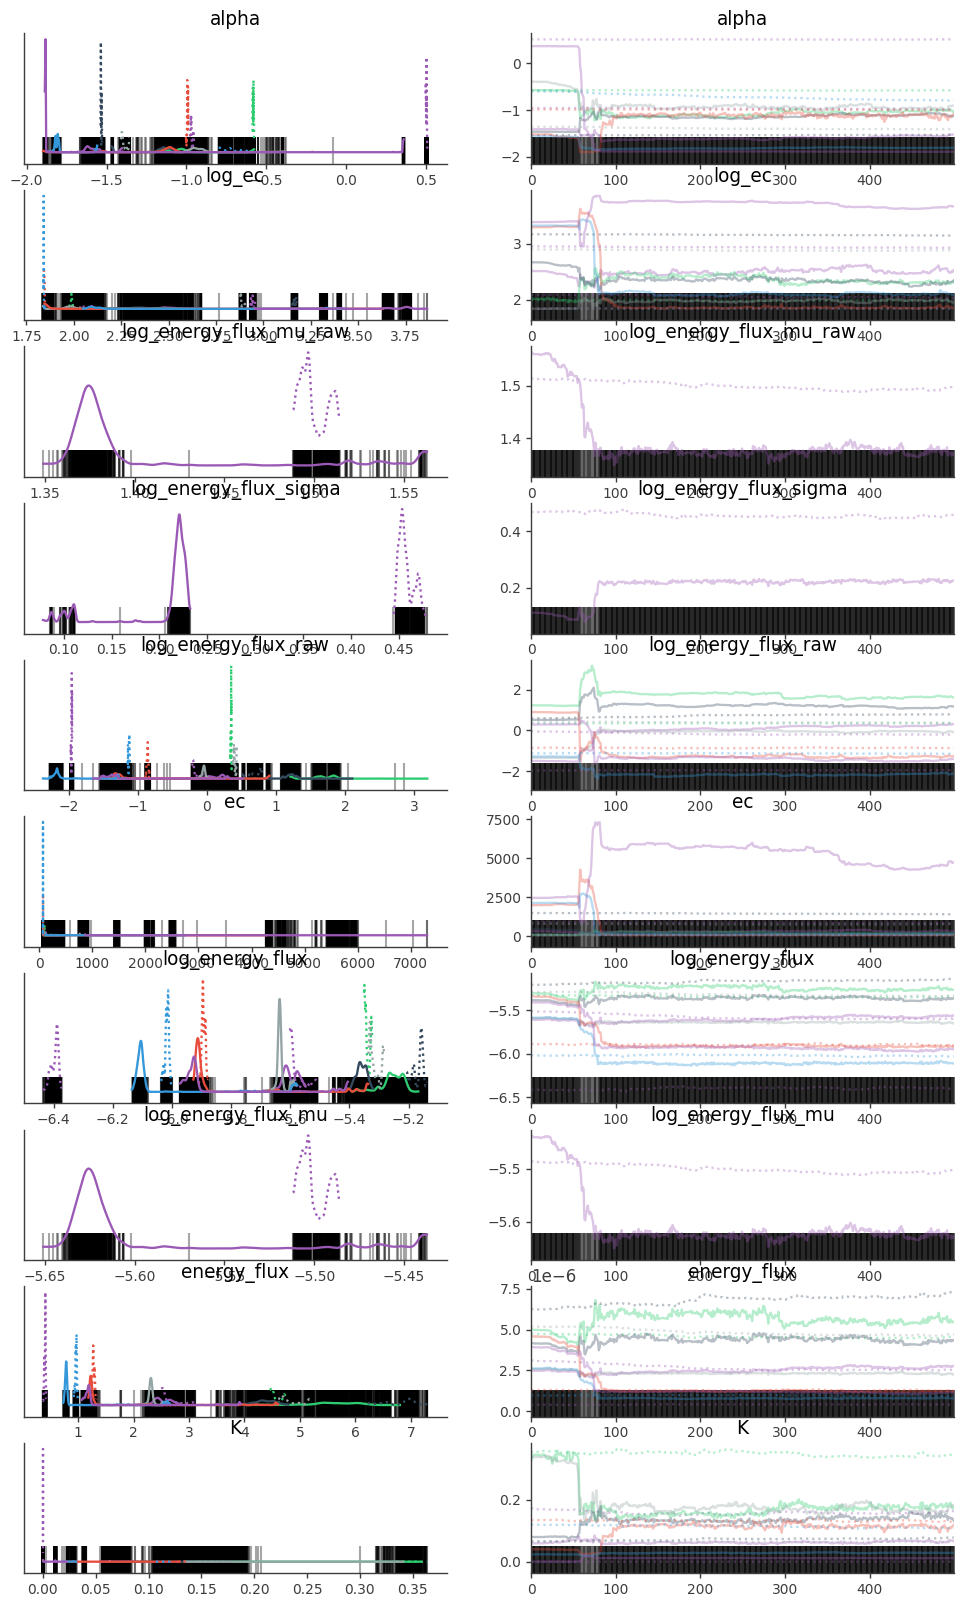

In [19]:
av.plot_trace(res)

In [20]:
bc = Band_Calderone(opt=0, a =10, b=1e4)
bc.beta.fix = True

In [21]:
id = 0

In [22]:
alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

ep = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**ep))


dl = ds.get_data_list_of_interval(id)

In [23]:
div.sum()

979

In [24]:
# bc = Band_Calderone(a=10.,b=1e4,opt=0)

# bc.beta.fix=True

bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

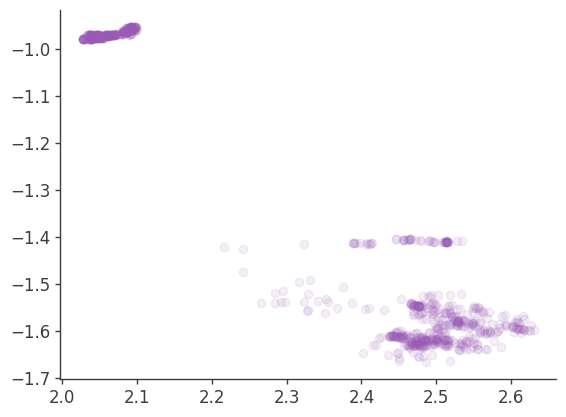

In [25]:
fig, ax = plt.subplots()


ax.scatter(ep, alpha, alpha=0.1)


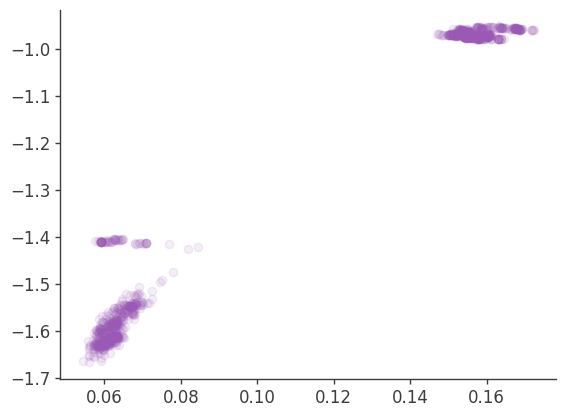

In [26]:
fig, ax = plt.subplots()


ax.scatter(K, alpha, alpha=0.1)

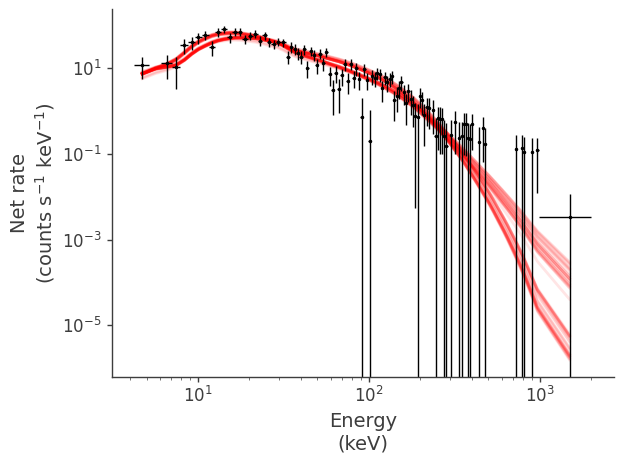

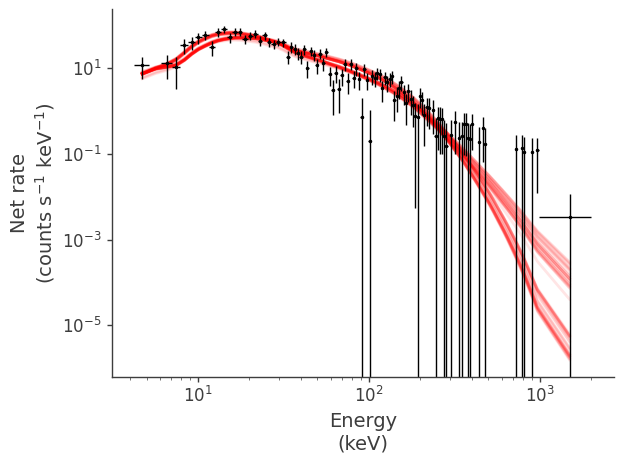

In [28]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [29]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [30]:
ba.fit()

Best fit values:



,result,unit
parameter,,
ps.spectrum.main.Cutoff_powerlaw.K,(1.53 -0.15 +0.16) x 10^-1,1 / (cm2 keV s)
ps.spectrum.main.Cutoff_powerlaw.index,-1.06 +/- 0.06,
ps.spectrum.main.Cutoff_powerlaw.xc,(1.80 -0.24 +0.27) x 10^2,keV



Correlation matrix:



1.00,0.95,-0.96
0.95,1.00,-0.91
-0.96,-0.91,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
b1,-119.996971
n2,26.394912
n3,9.079743
n5,30.564621
total,-53.957694



Values of statistical measures:



,statistical measures
AIC,-101.868145
BIC,-89.200415


TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

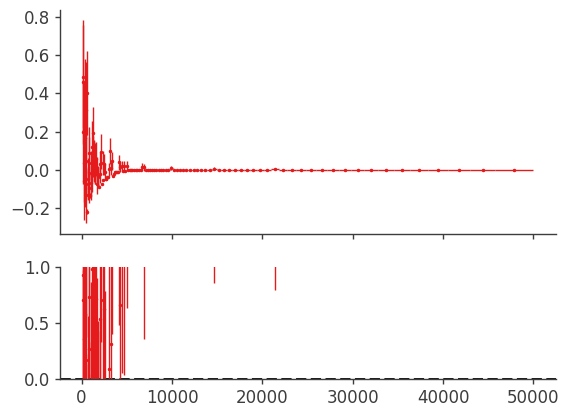

In [31]:
display_spectrum_model_counts(ba)

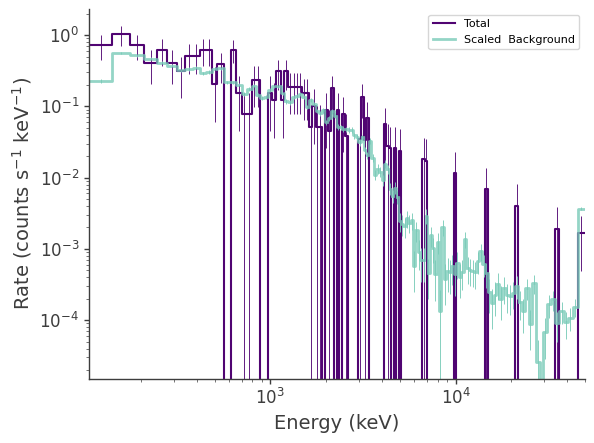

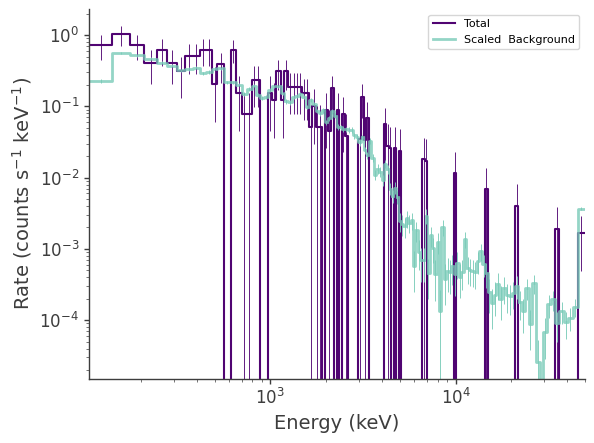

In [32]:
dl[0].view_count_spectrum()

In [33]:
cpl

* description: A power law multiplied by an exponential cutoff
  * formula: $ K~\frac{x}{piv}^{index}~\exp{-x/xc} $
  * parameters:
    * K:
      * value: 0.153285291246368
      * desc: Normalization (differential flux at the pivot value)
      * min_value: 1.0e-30
      * max_value: 1000.0
      * unit: keV-1 s-1 cm-2
      * is_normalization: true
      * delta: 0.1
      * free: true
    * piv:
      * value: 100.0
      * desc: Pivot value
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false
    * index:
      * value: -1.0588710935448429
      * desc: Photon index
      * min_value: -10.0
      * max_value: 10.0
      * unit: ''
      * is_normalization: false
      * delta: 0.2
      * free: true
    * xc:
      * value: 180.4134530684929
      * desc: Cutoff energy
      * min_value: 1.0
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 1.0
      * free: true